# Halo Model comparison with HMCODE and DARKEMU

We compare matter-matter, matter-galaxy and galaxy-galaxy power spectra. Halo model predictions are calculated with and without the non-linear halo-halo power spectrum correction. The results are then compared with both HMCode ([Mead et. al. 2015](https://arxiv.org/abs/1505.07833), [2021](https://arxiv.org/abs/2009.01858)), an augmented halo model code which has been calibrated against simulations and DarkEmu which is an emulator for the Dark Quest simulations ([Nishimichi et al. 2019](https://arxiv.org/abs/1811.09504) and 
[Miyatake et al. 2020](https://arxiv.org/abs/2101.00113)). 

In [1]:
# Standard import
import sys
import numpy as np
import matplotlib.pyplot as plt
import logging

# Third-party imports
import camb
# import pyhmcode as hmcode 
from dark_emulator import model_hod

# Imports from the halo model repo
sys.path.append('../src/')
import halomodel as halo
import darkquest

# Turn off matplotlib debug statements (caused by running Dark Quest)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

Lets set the cosmological parameters. The first set are the parameters that CAMB takes as input, but we also calculate a few derived parameters. If you want to set sigma_8 instead of As then set `sigma_8_set = True`

In [2]:
# Set cosmological parameters
Omega_c = 0.2537
Omega_b = 0.045
Omega_k = 0.0
h = 0.7
As = 2.1e-9
ns = 0.97
w = -1.0
wa = 0.0
m_nu = 0.06 # in eV
sigma_8_set = True # if true uses the following value
sigma_8 = 0.8

# derived parameters
wb = Omega_b*h**2
wc = Omega_c*h**2
Omega_nu_in =  m_nu/(93.1*h**2) # Note: this is very slightly different from what CAMB calculates
lnAs = np.log(1e10*As)
Omega_m_in = Omega_c+Omega_b+Omega_nu_in # Note: this is very slightly different from what CAMB calculates

Now lets set the parameters for the three methods that we want to compare. The critical linear over density, $\delta_{rm c}$= dc. The halo overdensity with respect to the background overdensity $\Delta_{\rm halo}$=Dv. Note that v in Dv stands for virial, but $\Delta_{\rm halo}$ is not always defined as the virial overdensity. 

In [3]:
# Wavenumbers
kmin, kmax = 1e-3, 10.
nk = 128
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Redshift
z = 0.001 # This is the redshift where we do the comparison. Dark Quest doesn't like z=0

# CAMB
zmax_CAMB = 2.
kmax_CAMB = 200.

# HOD parameters
Mmin_HOD = 10**13
sigma_HOD = 0.5
M0_HOD = Mmin_HOD
M1_HOD = 10**14
alpha_HOD = 1.0

# Halo model parameters
Mmin, Mmax = 1e9, 1e17
nM = 256
Ms = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)
halomodel_version = 'Tinker et al. (2010)'
dc = 1.686 
Dv = 200.
Mdef = 'M200'
central_condition = True
consider_variance = True
subtract_shotnoise = True
discrete_gal = True

Lets run CAMB to the get the linear power spectrum. We can also get the nonlinear power spectra from CAMB and compare results with that. Currently we have set the nonlinear power to `mead2020` which is the 2020 version of HMcode without baryon feedback. Check [CAMB documentation](https://camb.readthedocs.io/en/latest/nonlinear.html?highlight=nonlinear#camb.nonlinear.NonLinearModel) for other options.

In [4]:
# Sets cosmological parameters in camb to calculate the linear power spectrum
pars = camb.CAMBparams()

# This function sets standard and helium set using BBN consistency
pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
pars.set_dark_energy(w=w, wa=wa, dark_energy_model='ppf') 
pars.InitPower.set_params(As=As, ns=ns, r=0.)
pars.set_matter_power(redshifts=[z], kmax=kmax_CAMB) # Setup the linear matter power spectrum
camb.set_params(halofit_version='mead2020') # HMcode

# Extract parameters from CAMB
Omega_m = pars.omegam 
Omega_nu = pars.omeganu
Omega_v = 1.+Omega_k-Omega_m

# Redo normalisataion
if sigma_8_set:
    camb_results = camb.get_results(pars)
    sigma_8_init = (camb_results.get_sigma8()[[z].index(0.001)]).item()
    print('Initial sigma_8:', sigma_8)
    scaling = (sigma_8/sigma_8_init)**2
    As *= scaling
    lnAs = np.log(1e10*As)
    pars.InitPower.set_params(As=As, ns=ns, r=0.)

# Linear power
Pk_lin = camb.get_matter_power_interpolator(pars, 
                                            nonlinear=False, 
                                            hubble_units=True, 
                                            k_hunit=True, 
                                            kmax=kmax_CAMB,
                                            var1=camb.model.Transfer_tot,
                                            var2=camb.model.Transfer_tot, 
                                            zmax=zmax_CAMB,
                                           )
camb_results = camb.get_results(pars)
sigma_8 = (camb_results.get_sigma8()[[z].index(0.001)]).item()
if sigma_8_set: print('Final sigma_8:', sigma_8)
Pks_lin = Pk_lin.P(z, ks) # Single out the linear P(k) interpolator

# You can use this to find the non-linear powers spectra using CAMB (from HMcode)
# Create a power spectrum interpolation object from CAMB for the nonlinear power spectrum
Pk_nonlin = camb.get_matter_power_interpolator(pars, 
                                                nonlinear=True, 
                                                hubble_units=True, 
                                                k_hunit=True, 
                                                kmax=kmax_CAMB,
                                                var1=camb.model.Transfer_tot,
                                                var2=camb.model.Transfer_tot, 
                                                zmax=zmax_CAMB,
                                            )
Pks_HMcode = Pk_nonlin.P(z, ks)

Initial sigma_8: 0.8
Final sigma_8: 0.8000000000000004


Next lets setup the Dark Emulator

In [5]:
# Dark Quest

# Init HOD and cosmology
DQ_cosmo = darkquest.cosmology(wb=wb, wc=wc, Om_w=Omega_v, lnAs=lnAs, ns=ns, w=w)
emu = darkquest.init_emulator(DQ_cosmo)
hod = model_hod.darkemu_x_hod({'fft_num': 8})
hod.set_cosmology(DQ_cosmo.cosmology_array())

# Set HOD
gparam = {
    'logMmin': np.log10(Mmin_HOD), 
    'sigma_sq': sigma_HOD**2, 
    'logM1': np.log10(M1_HOD), 
    'alpha': alpha_HOD, 
    'kappa': M0_HOD/Mmin_HOD,
    'poff': 0.0, # Fraction of off-centered galaxies.
    'Roff': 0.1, # Typical off-centered scale with respect to R200m.
    'sat_dist_type': 'emulator', # Satellite distribution (emulator or NFW w/ DK2015 c-M relation).
    'alpha_inc': 0.0, # Incompleteness?
    'logM_inc': 13.57 # Incompleteness: For details, see More et al. (2015)
    } 
hod.set_galaxy(gparam)

# Get P(k) from Dark Quest
Pk_dq_mg = darkquest.get_Pk_gm(hod, ks, z)
Pk_dq_gg = darkquest.get_Pk_gg(hod, ks, z)
Pk_dq_mm = darkquest.get_Pk_mm(emu, ks, z, nonlinear=True)

Initialize Dark Quest
initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator

Dark Quest primary parameters
omega_b: 0.0220
omega_c: 0.1243
Omega_w: 0.7000
As [1e9]: 1.9037
ns: 0.9700
w: -1.0000

Dark Quest fixed parameters
omega_nu: 0.0006
Omega_k: 0.0000

Dark Quest derived parameters
Omega_m: 0.3000
Omega_b: 0.0450
omega_m: 0.1470
h: 0.7000
Omega_c: 0.2537
Omega_nu: 0.0013
m_nu [eV]: 0.0596

Derived sigma_8: 0.7992685423232867

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


Now we calculate $\beta_{\rm nl}$ which is used to create the nonlinear halo-halo power spectra. With fill_value=None we extrapolate the beta_NL values via the nearest-neighbor extrapolation

In [6]:
# Beta-NL 
Mmin_Bnl, Mmax_Bnl = 10**12.2, 10**15.1
nM_Bnl = 5
include_Bnl = True

if include_Bnl:
    Ms_small = np.logspace(np.log10(Mmin_Bnl), np.log10(Mmax_Bnl), nM_Bnl)
    beta_NL_small = darkquest.get_beta_NL(emu, Ms_small, ks, z, force_to_zero=6, mass_variable='mass')
    beta_NL = halo.interpolate_beta_NL(ks, Ms, Ms_small, beta_NL_small, scheme='RegularGridInterp', method='linear')
else:
    beta_NL = None


### Halo Model 
Now we initialise the halo model

In [7]:
# Initialise halo model
hmod = halo.model(z, Omega_m, name=halomodel_version, dc=dc, Dv=Dv, verbose=True)

Initialising halo model
Halo model: Tinker et al. (2010)
Redshift: 0.001
Scale factor: 0.999
Omega_m(z=0): 0.300
delta_c: 1.6860
Delta_v: 200.0
alpha: 0.368; beta: 0.589; gamma: 0.864; phi: -0.729; eta: -0.243
A: 1.000; a: 0.132
B: 0.183; b: 1.500
C: 0.265; c: 2.400



Get $\sigma(R)$ from CAMB. This is needed in the next step. 

In [8]:
# Get CAMB sigma(R)
Rs = hmod.Lagrangian_radius(Ms) # Lagrangian radii corresponding to halo masses
sigmaRs = camb_results.get_sigmaR(Rs, hubble_units=True)[[z].index(z)]

Initialise HOD and calculate power spectra

In [9]:
# HOD
# TODO: Dictionary for HOD model
N_cen, N_sat = halo.HOD_mean(Ms, method='Zheng et al. (2005)', 
                                    Mmin=Mmin_HOD, 
                                    sigma=sigma_HOD, 
                                    M0=M0_HOD, 
                                    M1=M1_HOD, 
                                    alpha=alpha_HOD)
if consider_variance:
    var_cen, var_sat, _ = halo.HOD_variance(N_cen, N_sat, central_condition)
else:
    var_cen = None; var_sat = None

# Halo window functions
rvs = hmod.virial_radius(Ms)
cs = halo.concentration(Ms, z, method='Duffy et al. (2008)', halo_definition=Mdef)
Uk = halo.window_function(ks, rvs, cs, profile='NFW')
Uk_cen = halo.window_function(ks, rvs, profile='delta')

# Densities
rhom = hmod.rhom
rhog = hmod.average(Ms, sigmaRs, N_cen+N_sat)

# Halo profiles
# Note that you need mass_tracer=True for matter profiles, and discrete_tracer=True and some variance for galaxy profiles
profile_mat = halo.profile.Fourier(ks, Ms, Uk, amp=Ms, norm=rhom, mass_tracer=True)
profile_cen = halo.profile.Fourier(ks, Ms, Uk_cen, amp=N_cen, norm=rhog, var=var_cen, discrete_tracer=discrete_gal)
profile_sat = halo.profile.Fourier(ks, Ms, Uk, amp=N_sat, norm=rhog, var=var_sat, discrete_tracer=discrete_gal)
profiles = {'m': profile_mat, 'c': profile_cen, 's': profile_sat}

# Calculate (and organize) the halo-model power spectrum
for beta in [None, beta_NL]:
    Pk_2h, Pk_1h, Pk_hm = hmod.power_spectrum(ks, Pks_lin, Ms, sigmaRs, profiles, 
                                          beta=beta,
                                          subtract_shotnoise=subtract_shotnoise,
                                          k_trunc=0.1,
                                          verbose=True)
    if beta is None:
        Pk_2h_mm = Pk_2h['m-m']
        Pk_1h_mm = Pk_1h['m-m']
        Pk_hm_mm = Pk_hm['m-m']
        Pk_2h_gg = Pk_2h['c-c']+2.*Pk_2h['c-s']+Pk_2h['s-s']
        Pk_1h_gg = Pk_1h['c-c']+2.*Pk_1h['c-s']+Pk_1h['s-s']
        Pk_hm_gg = Pk_hm['c-c']+2.*Pk_hm['c-s']+Pk_hm['s-s']
        Pk_2h_mg = Pk_2h['m-c']+Pk_2h['m-s']
        Pk_1h_mg = Pk_1h['m-c']+Pk_1h['m-s']
        Pk_hm_mg = Pk_hm['m-c']+Pk_hm['m-s']
    else:
        Pk_2h_bnl_mm = Pk_2h['m-m']
        Pk_1h_bnl_mm = Pk_1h['m-m']
        Pk_hm_bnl_mm = Pk_hm['m-m']
        Pk_2h_bnl_gg = Pk_2h['c-c']+2.*Pk_2h['c-s']+Pk_2h['s-s']
        Pk_1h_bnl_gg = Pk_1h['c-c']+2.*Pk_1h['c-s']+Pk_1h['s-s']
        Pk_hm_bnl_gg = Pk_hm['c-c']+2.*Pk_hm['c-s']+Pk_hm['s-s']
        Pk_2h_bnl_mg = Pk_2h['m-c']+Pk_2h['m-s']
        Pk_1h_bnl_mg = Pk_1h['m-c']+Pk_1h['m-s']
        Pk_hm_bnl_mg = Pk_hm['m-c']+Pk_hm['m-s']
# Note beta_nl has no impact on the 1 halo term. So all Pk_1h_bnl_* = Pk_1h_*

Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.27081515699242864
Calculating power: m-m
Calculating power: m-c
Calculating power: m-s
Calculating power: c-m
Calculating power: c-c
Calculating power: c-s
Calculating power: s-m
Calculating power: s-c
Calculating power: s-s
Halomodel calculation time [s]: 0.19926810264587402 

Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.27081515699242864
Calculating power: m-m
Calculating power: m-c
Calculating power: m-s
Calculating power: c-m
Calculating power: c-c
Calculating power: c-s
Calculating power: s-m
Calculating power: s-c
Calculating power: s-s
Halomodel calculation time [s]: 3.9259817600250244 



Setup for plotting

In [10]:
# Parameters
kmin_plt, kmax_plt = 1e-3, 25
Pkmin, Pkmax = 1e0, 1e5
rmin, rmax = 0.79, 1.21

plot_accuracy_lines = False
plot_accuracy_block = True
include_bnl_mm = True

# Line styles
lab_mm = 'matter'; lab_mg = 'matter-galaxy'; lab_gg = 'galaxy'
lab_li = 'linear'; lab_hm = 'standard halo model'; lab_nl = 'with non-linear halo bias'
col_li = 'black'; col_mm = 'C0'; col_mg = 'C1'; col_gg = 'C2'
ls_2h = '-.'; ls_1h = ':'; ls_hm = '-'; ls_hm_res = '-'; ls_nl_res = '--'
# alpha_model = 0.5

# These are the "reference" values that we compare to
Pks_ref = [Pks_HMcode, Pk_dq_mg, Pk_dq_gg]
cols    = [col_mm, col_mg, col_gg]
labs_model = ['HMcode', 'DarkEmu', 'DarkEmu']

# Halo model without beta_nl
Pks_2h = [Pk_2h_mm, Pk_2h_mg, Pk_2h_gg]
Pks_1h = [Pk_1h_mm, Pk_1h_mg, Pk_1h_gg]
Pks_hm = [Pk_hm_mm, Pk_hm_mg, Pk_hm_gg]
cols = [col_mm, col_mg, col_gg]
labs = [lab_mm, lab_mg, lab_gg]
if include_Bnl:
    Pks_2h_bnl = [Pk_2h_bnl_mm, Pk_2h_bnl_mg, Pk_2h_bnl_gg]
    Pks_hm_bnl = [Pk_hm_bnl_mm, Pk_hm_bnl_mg, Pk_hm_bnl_gg]


Now plot the figure for the Halo model Review.

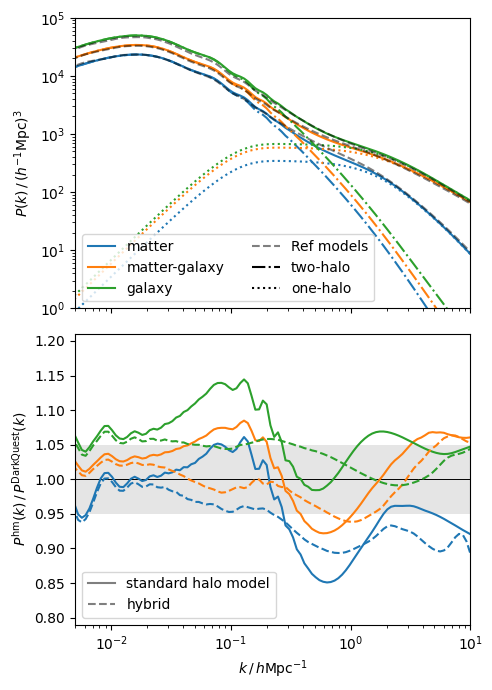

In [11]:
# Parameters
kmin_plt, kmax_plt = 5e-3, 1e1
Pkmin, Pkmax = 1e0, 1e5
rmin, rmax = 0.79, 1.21

plot_accuracy_lines = False
plot_accuracy_block = True
include_bnl_mm = True

# Line styles
lab_mm = 'matter'; lab_mg = 'matter-galaxy'; lab_gg = 'galaxy'
lab_li = 'linear'; lab_hm = 'standard halo model'; lab_nl = 'with non-linear halo bias'
col_li = 'black'; col_mm = 'C0'; col_mg = 'C1'; col_gg = 'C2'
ls_2h = '-.'; ls_1h = ':'; ls_hm = '-'; ls_hm_res = '-'; ls_nl_res = '--'
# alpha_model = 0.5

# These are the "reference" values that we compare to
Pks_ref = [Pks_HMcode, Pk_dq_mg, Pk_dq_gg]
Pks_ref = [Pk_dq_mm, Pk_dq_mg, Pk_dq_gg]
cols    = [col_mm, col_mg, col_gg]
labs_model = ['HMcode', 'DarkEmu', 'DarkEmu']

# Halo model without beta_nl
Pks_2h = [Pk_2h_mm, Pk_2h_mg, Pk_2h_gg]
Pks_1h = [Pk_1h_mm, Pk_1h_mg, Pk_1h_gg]
Pks_hm = [Pk_hm_mm, Pk_hm_mg, Pk_hm_gg]

cols = [col_mm, col_mg, col_gg]
labs = [lab_mm, lab_mg, lab_gg]
if include_Bnl:
    Pks_2h_bnl = [Pk_2h_bnl_mm, Pk_2h_bnl_mg, Pk_2h_bnl_gg]
    Pks_hm_bnl = [Pk_hm_bnl_mm, Pk_hm_bnl_mg, Pk_hm_bnl_gg]
    Pks_hybrid_bnl = [Pks_HMcode, Pk_hm_bnl_mg, Pk_hm_bnl_gg]
#     Pks_hybrid_bnl = [Pks_HMcode, Pk_hm_bnl_mg/Pk_hm_bnl_mm*Pks_HMcode, Pk_hm_bnl_gg/Pk_hm_bnl_mm*Pks_HMcode]
    Pks_hybrid_hm = [Pks_HMcode, Pk_hm_mg/Pk_hm_mm*Pks_HMcode, Pk_hm_gg/Pk_hm_mm*Pks_HMcode]
    Pks_hybrid_dq = [Pks_HMcode, Pk_dq_mg/Pk_dq_mm*Pks_HMcode, Pk_dq_gg/Pk_dq_mm*Pks_HMcode]
    Pks_hybrid_bnl_dq = [Pks_HMcode, Pk_hm_bnl_mg/Pk_dq_mm*Pks_HMcode, Pk_hm_bnl_gg/Pk_dq_mm*Pks_HMcode]

Pks_hybrid = Pks_hybrid_bnl.copy()

# Initialise
plt.subplots(2, 1, figsize=(5, 7), dpi=100, sharex=True)

# P(k)
plt.subplot(2, 1, 1)

# Stadard halo model predictions without non-linear halo bias 
for (Pk_2h, Pk_1h, Pk_hm, col, lab) in zip(Pks_2h, Pks_1h, Pks_hm, cols, labs):
    for (Pk, ls, lab) in zip([Pk_2h, Pk_1h, Pk_hm], [ls_2h, ls_1h, ls_hm], [None, None, lab]):
        plt.plot(ks, Pk, ls=ls, color=col, label=lab)

# Reference models
for (Pk, col, lab) in zip(Pks_ref, cols, labs):
    plt.plot(ks, Pk, color='k', ls='--', alpha=0.5)

plt.plot(np.nan, ls='--', color='black', alpha=0.5, label='Ref models')

for ls, lab in zip([ls_2h, ls_1h], ['two-halo', 'one-halo']):
    plt.plot(np.nan, ls=ls, color='black', label=lab)

# Axes
plt.xticks([])
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P(k)\,/\,(h^{-1}\mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.yscale('log')
plt.legend(ncol=2, loc='lower left')

# Residual with HMcode and Dark Emulator
plt.subplot(2, 1, 2)

# Horizontal lines
plt.axhline(1., color='black', lw=.7)
if plot_accuracy_lines:
    for x in [0.9, 0.99, 1.01, 1.1]:
        plt.axhline(x, color='black', ls=':')
if plot_accuracy_block:
    plt.axhspan(0.95, 1.05, alpha=0.1, color='black', lw=0.)

# Residual of standard halo model
# plt.plot(ks, Pk_lin_camb/Pks_HMcode, color=col_li, label=lab_li)
for (Pk_hm, Pk_ref, col) in zip(Pks_hm, Pks_ref, cols):
    plt.plot(ks, Pk_hm/Pk_ref, color=col, ls=ls_hm_res)

# Residual of beta_nl halo model
if include_Bnl:
    for (Pk_hm, Pk_ref, col) in zip(Pks_hm_bnl, Pks_ref, cols):
        if (not include_bnl_mm) and (col == col_mm):
            continue 
        else:
            plt.plot(ks, Pk_hm/Pk_ref, color=col, ls=ls_nl_res)

# Labels
plt.plot(np.nan, color='black', alpha=0.5, ls=ls_hm_res, label=lab_hm)
if include_Bnl:
    plt.plot(np.nan, color='black', alpha=0.5, ls=ls_nl_res, label='hybrid')

# Axes
plt.xlabel(r'$k\,/\,h\mathrm{Mpc}^{-1}$')
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P^\mathrm{hm}(k)\,/\,P^\mathrm{DarkQuest}(k)$')
plt.ylim((rmin, rmax))
plt.legend(loc='lower left')

outfile = 'plots/hm_comp.pdf'
# Finalise
plt.tight_layout()
plt.savefig(outfile,bbox_inches='tight')
plt.show()

The top plot shows the power spectra from the standard halo model (solid) and the reference models (dashed). The 1 and 2 halo term contributions to the halo model are shown separately. 
For the bottom plot we show ratios of the halo model predictions with respect to reference power spectra.
The reference values come from HMcode for matter power spectrum and the Dark Emulator for galaxy and galaxy-matter power spectra. We show the result for both the standrad and with non-linear halo bias correction halo models.

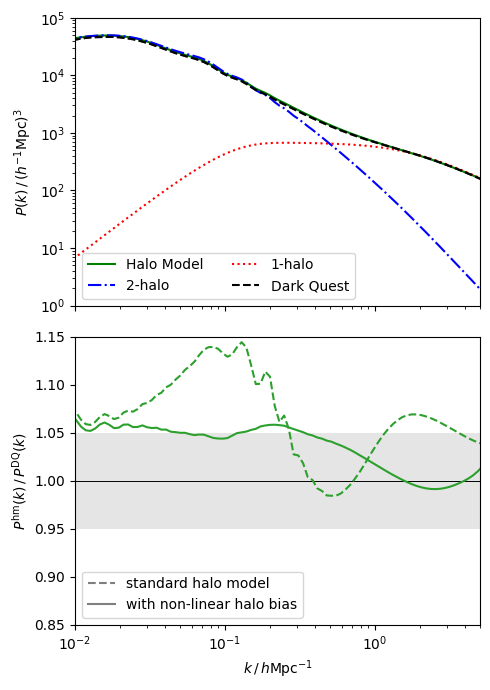

In [12]:
# Parameters
kmin_plt, kmax_plt = 1e-2, 5
Pkmin, Pkmax = 1e0, 1e5
rmin, rmax = 0.85, 1.15

plot_accuracy_lines = False
plot_accuracy_block = True
include_bnl_mm = True

# Line styles
lab_mm = 'matter'; lab_mg = 'matter-galaxy'; lab_gg = 'galaxy'
lab_li = 'linear'; lab_hm = 'standard halo model'; lab_nl = 'with non-linear halo bias'
col_li = 'black'; col_mm = 'C0'; col_mg = 'C1'; col_gg = 'C2'
ls_2h = '-.'; ls_1h = ':'; ls_hm = '-'; ls_hm_res = '-'; ls_nl_res = '--'
# alpha_model = 0.5

# These are the "reference" values that we compare to
Pks_ref = [Pk_dq_gg]
# Pks_ref = [Pk_dq_mm, Pk_dq_mg, Pk_dq_gg]
cols    = [ col_gg]
labs_model = ['DarkEmu']

# Halo model without beta_nl
Pks_2h = [Pk_2h_gg]
Pks_1h = [Pk_1h_gg]
Pks_hm = [Pk_hm_gg]

cols = [ col_gg]
labs = [lab_gg]
if include_Bnl:
    Pks_2h_bnl = [Pk_2h_bnl_gg]
    Pks_hm_bnl = [Pk_hm_bnl_gg]
    Pks_hybrid_bnl = [Pk_hm_bnl_gg]

# Initialise
plt.subplots(2, 1, figsize=(5, 7), dpi=100, sharex=True)

# P(k)
plt.subplot(2, 1, 1)

# Stadard halo model predictions without non-linear halo bias 
plt.plot(ks, Pk_hm_bnl_gg, ls='-', color='g', label='Halo Model')
plt.plot(ks, Pk_2h_gg, ls='-.', color='b', label='2-halo')
plt.plot(ks, Pk_1h_gg, ls=':', color='r', label='1-halo')
plt.plot(ks, Pk_dq_gg, ls='--', color='k', label='Dark Quest')

# Reference models
for (Pk, col, lab) in zip(Pks_ref, cols, labs):
    plt.plot(ks, Pk, color='k', ls='--',alpha=0.5)

# Axes
plt.xticks([])
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P(k)\,/\,(h^{-1}\mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.yscale('log')
plt.legend(ncol=2, loc='lower left')

# Residual with HMcode and Dark Emulator
plt.subplot(2, 1, 2)

# Horizontal lines
plt.axhline(1., color='black', lw=.7)
if plot_accuracy_lines:
    for x in [0.9, 0.99, 1.01, 1.1]:
        plt.axhline(x, color='black', ls=':')
if plot_accuracy_block:
    plt.axhspan(0.95, 1.05, alpha=0.1, color='black', lw=0.)
    
# Residual of standard halo model
for (Pk_hm, Pk_ref, col) in zip(Pks_hm, Pks_ref, cols):
    plt.plot(ks, Pk_hm/Pk_ref, color=col, ls='--')

# Residual of beta_nl halo model
if include_Bnl:
    for (Pk_hm, Pk_ref, col) in zip(Pks_hm_bnl, Pks_ref, cols):
        if (not include_bnl_mm) and (col == col_mm):
            continue 
        else:
            plt.plot(ks, Pk_hm/Pk_ref, color=col, ls='-')
    
# Labels
plt.plot(np.nan, color='black', alpha=0.5, ls='--', label=lab_hm)
if include_Bnl:
    plt.plot(np.nan, color='black', alpha=0.5, ls='-', label='with non-linear halo bias')
        
# Axes
plt.xlabel(r'$k\,/\,h\mathrm{Mpc}^{-1}$')
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P^\mathrm{hm}(k)\,/\,P^\mathrm{DQ}(k)$')
plt.ylim((rmin, rmax))
plt.legend(loc='lower left')

# Finalise
plt.tight_layout()
plt.show()